In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.metrics import classification_report
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from nltk.tokenize import RegexpTokenizer
import string
from PIL import Image
import requests
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler

In [189]:
df = pd.read_pickle('book.pkl','zip')

In [190]:
df.columns

Index(['title', 'authors', 'average_rating', 'isbn13', '  num_pages',
       'ratings_count', 'publication_date', 'publisher'],
      dtype='object')

In [191]:
most_occurent_books=df['title'].value_counts()[:15]


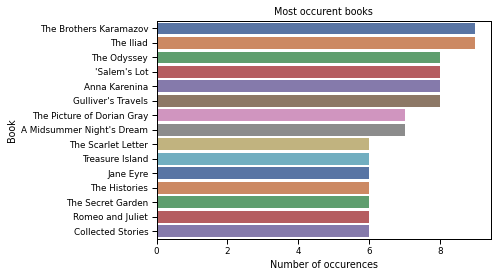

In [192]:
sns.barplot(x=most_occurent_books,y=most_occurent_books.index,palette='deep')
plt.title('Most occurent books')
plt.xlabel('Number of occurences')
plt.ylabel('Book')
plt.show()

In [193]:
Freq_authors=df['authors'].value_counts()[:10]


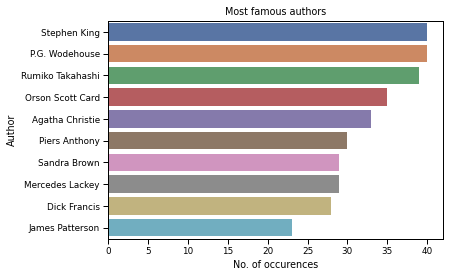

In [194]:
sns.barplot(x=Freq_authors,y=Freq_authors.index,palette='deep')
plt.title('Most famous authors')
plt.xlabel('No. of occurences')
plt.ylabel('Author')
plt.show()

/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='average_rating', ylabel='title'>

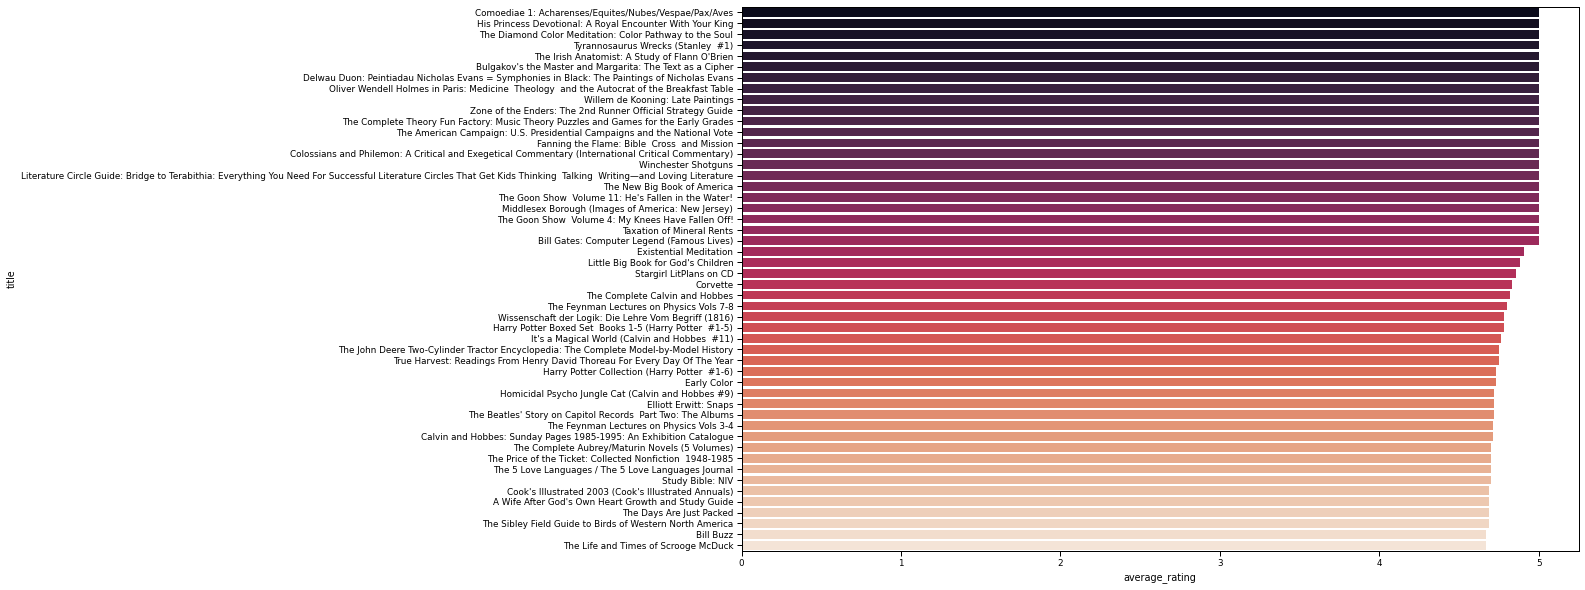

In [195]:
plt.figure(figsize=(15,10))
plt.xlabel('rating')
plt.ylabel('book')
sns.barplot(most_rated['average_rating'], most_rated.index, palette='rocket')

<AxesSubplot:>

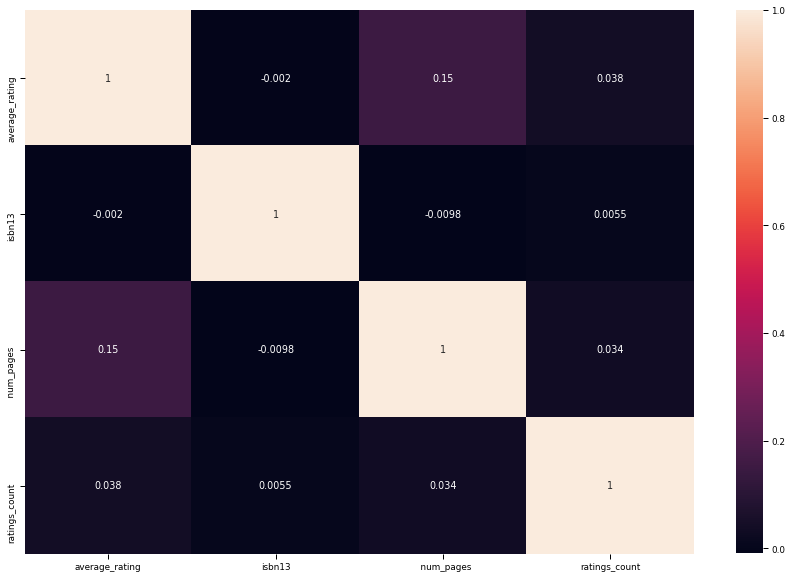

In [196]:
plt.figure(figsize=(15,10))

corr=df.corr()
sns.heatmap(corr,annot=True)

<AxesSubplot:xlabel='average_rating', ylabel='Count'>

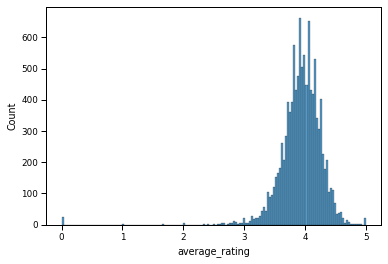

In [197]:
sns.histplot(df['average_rating'])


In [198]:
df_ratings=df[['title','authors','average_rating']]


In [199]:
demo=df_ratings.sort_values('average_rating',ascending=False).set_index('title')


In [200]:
demo1=df_ratings.sort_values('average_rating',ascending=False).set_index('authors')


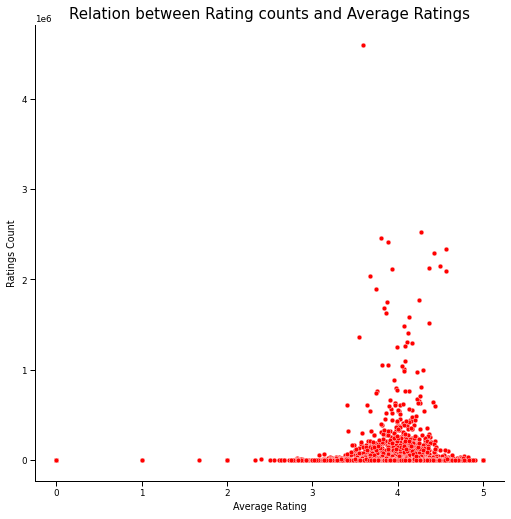

In [201]:
ax = sns.relplot(data=df, x="average_rating", y="ratings_count", color = 'red', sizes=(100, 200), height=7, marker='o')
plt.title("Relation between Rating counts and Average Ratings",fontsize = 15)
ax.set_axis_labels("Average Rating", "Ratings Count")

In [202]:
df2 = df.copy()

In [203]:
df2.loc[ (df2['average_rating'] >= 0) & (df2['average_rating'] <= 1), 'rating_between'] = "between 0 and 1"
df2.loc[ (df2['average_rating'] > 1) & (df2['average_rating'] <= 2), 'rating_between'] = "between 1 and 2"
df2.loc[ (df2['average_rating'] > 2) & (df2['average_rating'] <= 3), 'rating_between'] = "between 2 and 3"
df2.loc[ (df2['average_rating'] > 3) & (df2['average_rating'] <= 4), 'rating_between'] = "between 3 and 4"
df2.loc[ (df2['average_rating'] > 4) & (df2['average_rating'] <= 5), 'rating_between'] = "between 4 and 5"

In [204]:
df2.head(20)

,title,authors,average_rating,isbn13,num_pages,ratings_count,publication_date,publisher,rating_between
bookID,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,9780439785969,652,2095690,9/16/2006,Scholastic Inc.,between 4 and 5
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,9780439358071,870,2153167,9/1/2004,Scholastic Inc.,between 4 and 5
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,9780439554893,352,6333,11/1/2003,Scholastic,between 4 and 5
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,9780439655484,435,2339585,5/1/2004,Scholastic Inc.,between 4 and 5
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,9780439682589,2690,41428,9/13/2004,Scholastic,between 4 and 5
9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,9780976540601,152,19,4/26/2005,Nimble Books,between 3 and 4
10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,9780439827607,3342,28242,9/12/2005,Scholastic,between 4 and 5
12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,9780517226957,815,3628,11/1/2005,Gramercy Books,between 4 and 5
13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,9780345453747,815,249558,4/30/2002,Del Rey Books,between 4 and 5


In [205]:
rating_df = pd.get_dummies(df2['rating_between'])
rating_df.head()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5
bookID,,,,,
1,0,0,0,0,1
2,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
8,0,0,0,0,1


In [206]:
rating_df.tail()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5
bookID,,,,,
45631,0,0,0,0,1
45633,0,0,0,0,1
45634,0,0,0,1,0
45639,0,0,0,1,0
45641,0,0,0,1,0


In [207]:
features = pd.concat([rating_df, df2['average_rating'], df2['ratings_count']], axis=1)
features.head()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.57,2095690
2,0,0,0,0,1,4.49,2153167
4,0,0,0,0,1,4.42,6333
5,0,0,0,0,1,4.56,2339585
8,0,0,0,0,1,4.78,41428


In [208]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [209]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(features)
idlist = model.kneighbors(features)

In [221]:
def BookRecommender(book_name):
    book_list_name = []
    book_id = df2[df2['title'] == book_name].index
    book_id = book_id[0]
    for newid in idlist[book_id]:
        book_list_name.append(df2.iloc[newid].title)
    return book_list_name[3:4]

In [222]:
BookNames = BookRecommender('Harry Potter and the Half-Blood Prince (Harry Potter  #6)')
BookNames

[bookID
 5        Harry Potter and the Prisoner of Azkaban (Harr...
 15881    Harry Potter and the Chamber of Secrets (Harry...
 2        Harry Potter and the Order of the Phoenix (Har...
 1        Harry Potter and the Half-Blood Prince (Harry ...
 34       The Fellowship of the Ring (The Lord of the Ri...
 5907                   The Hobbit  or There and Back Again
 Name: title, dtype: object]